In [ ]:
!pip install git+https://github.com/prolearner/hypertorch

  Cloning https://github.com/prolearner/hypertorch to /tmp/pip-req-build-x1nqs1w0
  Running command git clone -q https://github.com/prolearner/hypertorch /tmp/pip-req-build-x1nqs1w0
  Created wheel for hypergrad: filename=hypergrad-0.1-cp36-none-any.whl size=6648 sha256=3afc1b6df94b0f562c402569cc934269c55a50a0fa15e6b20ad04334a036b598
  Stored in directory: /tmp/pip-ephem-wheel-cache-8zwuyqca/wheels/87/98/9c/443338661f6be492cbc5fb006151190595902bab536abc532c
Successfully built hypergrad


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torch.nn.functional as F
import pickle
import itertools
import tqdm
import hypergrad as hg
from mlmodel import *
import utils
import torch.nn.functional as F
import numpy as np
from sparsemax import Sparsemax

In [ ]:
d = 40 # feature dim
d_a = 12 #dim of attr
d_e = 3 #dim of attr embedding
num_task = 100 # num of tasks
train_task_size = 100 #
test_task_size = 100
kb_size = 10

#my thought: linear

In [ ]:
def build_c_byDist(e_item, e_kbb):
  c = []
  for i in range(e_item.size()[1]):
    # print(e_train[:, i].size(), e_train[:, i], e_train[:,i].view(d_e, 1))
    # print(e_kb.size(), e_kb)
    #print(e_kb - e_train[:,i].view(d_e, 1))
    dist = e_kbb - e_item[:,i].view(e_item.size()[0], 1)
    dist = torch.norm(dist, p=2, dim=0)
    #print(dist.size(), dist, torch.mul(-1, dist))
    exp_neg_dist = torch.exp(torch.mul(-1, dist))
    #print(exp_neg_dist)
    c.append(exp_neg_dist.unsqueeze(0))
    
  c = torch.cat(c, dim=0)
  return c

def analytical_soln(w_kbb, e_item, e_kbb):
  #find analytical son for one specific novel task
  '''
  c - row vector 
  w_kbb 
  '''
  
  c = build_c_byDist(e_item, e_kbb)

  w = [torch.sum(torch.mul(c[i], w_kbb), dim=1, keepdim=True)/torch.sum(c[i]) for i in range(e_item.size()[1])]
  w = torch.cat(w, dim=1)
  return w

def outer_loss(x_loss, y_loss, w_kbb, e_item, e_kbb):
  
  w_pred = analytical_soln(w_kbb, e_item, e_kbb)
  #print(w_pred.t().size(), x_loss.size())
  pred_y = torch.matmul(w_pred.t(), x_loss)
  loss = F.mse_loss(pred_y, y_loss)
  
  return loss



In [ ]:
a_kb = torch.randn(d_a, kb_size)
a_train = torch.randn(d_a, train_task_size)
a_test = torch.randn(d_a, test_task_size)

#M = torch.rand(d_e, d_a)
M = torch.ones((d_e, d_a))
e_kb = torch.matmul(M, a_kb)
e_train = torch.matmul(M, a_train)
e_test = torch.matmul(M, a_test)

w_kb = torch.randn(d, kb_size)
#construct matrix c
c_train = build_c_byDist(e_train, e_kb)
print(c_train.size())
c_test = build_c_byDist(e_test, e_kb)
print(c_test.size())

# print(c_train[0])
# print(w_kb.size())
# print(torch.mul(c_train[0], w_kb)/w_kb)
w_train = [torch.sum(torch.mul(c_train[i], w_kb), dim=1, keepdim=True)/torch.sum(c_train[i]) for i in range(train_task_size)]
w_train = torch.cat(w_train, dim=1)
print(w_train.size())
solved_w = analytical_soln(w_kb, e_train, e_kb)
print('cehck analutical soln ', torch.norm(w_train- solved_w))

w_test = [torch.sum(torch.mul(c_test[i], w_kb), dim=1, keepdim=True)/torch.sum(c_test[i]) for i in range(test_task_size)]
w_test = torch.cat(w_test, dim=1)
print(w_test.size())

torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([40, 100])
cehck analutical soln  tensor(0.)
torch.Size([40, 100])


In [ ]:
x_train = torch.randn(d, 200)
y_train = torch.matmul(w_train.t(), x_train)
print(y_train.size())
loss = outer_loss(x_train, y_train, w_kb, e_train, e_kb)
print('check outer loss ', loss)

x_test = torch.randn(d, 200)
y_test = torch.matmul(w_test.t(), x_test)

torch.Size([100, 200])
check outer loss  tensor(0.)


In [ ]:
#lam_learn = [torch.ones_like(M, requires_grad=True)]
lam_learn = [torch.randn((d_e, d_a), requires_grad=True)]
opt = torch.optim.Adam(lam_learn, lr=1e-2)
totIter = 1000


e_k = torch.matmul(lam_learn[0], a_kb)
e_t = torch.matmul(lam_learn[0], a_train)
o_loss = outer_loss(x_train, y_train, w_kb, e_t, e_k)
print('outer loss {}'.format(o_loss))

for tot in range(totIter):
  e_k = torch.matmul(lam_learn[0], a_kb)
  e_t = torch.matmul(lam_learn[0], a_train)
  o_loss =  outer_loss(x_train, y_train, w_kb, e_t, e_k)

  opt.zero_grad()
  o_loss.backward()
  opt.step()
  print('outer loss {}'.format(o_loss))
  
  #print('lam_learn ', lam_learn)
print('lam_learn ', lam_learn)
print('M ', M)
e_k = torch.matmul(lam_learn[0], a_kb)
e_t = torch.matmul(lam_learn[0], a_test)
o_loss = outer_loss(x_test, y_test, w_kb, e_t, e_k)
print('test set: outer loss {}'.format(o_loss))

outer loss 32.261959075927734
outer loss 32.261959075927734
outer loss 31.914905548095703
outer loss 31.57183837890625
outer loss 31.23643684387207
outer loss 30.911802291870117
outer loss 30.599634170532227
outer loss 30.300189971923828
outer loss 30.012868881225586
outer loss 29.736881256103516
outer loss 29.471261978149414
outer loss 29.21319007873535
outer loss 28.956090927124023
outer loss 28.701675415039062
outer loss 28.453065872192383
outer loss 28.211074829101562
outer loss 27.976152420043945
outer loss 27.748674392700195
outer loss 27.528963088989258
outer loss 27.31707763671875
outer loss 27.112611770629883
outer loss 26.914562225341797
outer loss 26.72142791748047
outer loss 26.53152847290039
outer loss 26.34331512451172
outer loss 26.155559539794922
outer loss 25.96741485595703
outer loss 25.778409957885742
outer loss 25.58842658996582
outer loss 25.397693634033203
outer loss 25.206722259521484
outer loss 25.01622772216797
outer loss 24.826967239379883
outer loss 24.639587

#my thought: non-linear

In [ ]:
# non_lin_transform_toA = FuncRecursiveNet([
#         FLinearLayer(10, False), 
#         FActivation(F.relu),                                 
#         FLinearLayer(3, True),
#     ])


non_lin_toEm = FuncRecursiveNet([
        FLinearLayer(d_e*3+1, True),
        FActivation(F.relu),
        FLinearLayer(d_e*2+1, True), 
        FActivation(F.relu),                                 
        FLinearLayer(d_e, True),
    ])

non_lin_toEm_learn = FuncRecursiveNet([
        FLinearLayer(d_e*3, True),
        FActivation(F.relu),
        FLinearLayer(d_e*2, True), 
        FActivation(F.relu),                                 
        FLinearLayer(d_e, True),
    ])

#Attention Test

In [ ]:
def analytical_soln_atten(w_kbb, e_item, e_kbb, w_atten):
  #find analytical son for one specific novel task
  '''
  c - row vector 
  w_kbb 
  '''
  affinity = build_c_byAtten(e_item, e_kbb, w_atten)

  softmax = nn.Softmax(dim=1)
  c_newnew = softmax(affinity)
  
  w = torch.matmul(c_newnew, w_kbb.t())

  return w.t()

def outer_loss_atten(x_loss, y_loss, w_kbb, e_item, e_kbb, w_atten):
  
  w_pred = analytical_soln_atten(w_kbb, e_item, e_kbb, w_atten)
  
  #print(w_pred.t().size(), x_loss.size())
  pred_y = torch.matmul(w_pred.t(), x_loss)
  loss = F.mse_loss(pred_y, y_loss)
  
  return loss

def build_c_byAtten(e_item, e_kbb, w_atten):
  dim = e_item.size()[0]
  affinity = torch.matmul(e_item.t(), w_atten)
  affinity = torch.matmul(affinity, e_kbb)
  
  #torch.sqrt(torch.tensor(e_item.size()[0], dtype=float))

  return affinity
  
def outer_loss_class_atten(x_loss, y_loss, w_kbb, e_item, e_kbb, hp, regu_coef=0.01):
  
  w_pred = analytical_soln_atten(w_kbb, e_item, e_kbb, hp)
  #print(w_pred.t().size(), x_loss.size())
  logit = torch.matmul(w_pred.t(), x_loss)
  pred_y = torch.sigmoid(logit)
  # loss = F.mse_loss(pred_y, y_loss)
  try:
    loss = F.binary_cross_entropy(pred_y, y_loss)
  except:
    print('e_kbb ', e_kbb)
    print('e_item ', e_item)
    print('w_pred ', w_pred)
    # print('pred_y ', pred_y)
    print('c ', build_c_byAtten(e_item, e_kbb))

  # l2loss = torch.tensor(0., dtype=float, requires_grad=True)
  # for p in hp:
  #   l2loss = l2loss + torch.norm(p, p=2)
  return loss 

def getPred(x_loss, w_pred):
  
  logit = torch.matmul(w_pred.t(), x_loss)
  pred = torch.sigmoid(logit)
  pred[pred>=0.5] = torch.ones_like(pred[pred>=0.5])
  pred[pred<0.5] = torch.zeros_like(pred[pred<0.5])

  return pred

def acc_binary_atten(x_loss, y_loss, w_kbb, e_item, e_kbb, w_atten):
  w_pred = analytical_soln_atten(w_kbb, e_item, e_kbb, w_atten)
  #print(w_pred.t().size(), x_loss.size())
  pred = getPred(x_loss, w_pred)
  compare = (pred == y_loss)
  #print('compare ', compare.size(), compare)
  compare = torch.sum(compare, dim=1)
  #print('compare ', compare.size(), compare)
  #print(y_loss.size()[1])
  acc = torch.mean(compare.float())
  #print('acc ', acc)
  mean_acc = acc/y_loss.size()[1]
  #print(mean_acc)
  
  return mean_acc

In [ ]:
'''
Sparsemax utility
'''
sparsemax = Sparsemax(dim=1)
softmax = torch.nn.Softmax(dim=1)

logits = torch.randn(2, 5)
print("\nLogits")
print(logits)

softmax_probs = softmax(logits)
print("\nSoftmax probabilities")
print(softmax_probs)

sparsemax_probs = sparsemax(logits)
print("\nSparsemax probabilities")
print(sparsemax_probs)


Logits
tensor([[ 1.0910,  1.0434,  0.8470, -0.4349,  0.8394],
        [-0.4407, -1.0627, -1.3407, -0.8610,  0.8660]])

Softmax probabilities
tensor([[0.2680, 0.2555, 0.2099, 0.0583, 0.2083],
        [0.1589, 0.0853, 0.0646, 0.1044, 0.5869]])

Sparsemax probabilities
tensor([[0.3859, 0.3382, 0.1418, 0.0000, 0.1342],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000]])


In [ ]:
'''
KL divergence utility
'''
# this is the same example in wiki
P = torch.Tensor([0.36, 0.48, 0.16])
Q = torch.Tensor([0.333, 0.333, 0.333])

print('mannually ',(P * (P / Q).log()).sum())
# tensor(0.0863), 10.2 µs ± 508

print('torch ',F.kl_div(Q.log(), P, None, None, 'sum'))
# tensor(0.0863), 14.1 µs ± 408 ns

P1 = torch.Tensor([0.32, 0.6, 0.08])
Q1 = torch.Tensor([0.3, 0.5, 0.2])
print('mannually ',(P1 * (P1 / Q1).log()).sum())
# tensor(0.0567), 10.2 µs ± 508

print('torch ',F.kl_div(Q1.log(), P1, None, None, 'sum'))
# tensor(0.0567), 14.1 µs ± 408 ns
print(0.0567+0.0863)
P_all = torch.cat([torch.unsqueeze(P, dim=0), torch.unsqueeze(P1, dim=0)], dim=0)
print(P_all)
Q_all = torch.cat([torch.unsqueeze(Q, dim=0), torch.unsqueeze(Q1, dim=0)], dim=0)
print(Q_all)
print('torch ',F.kl_div(Q_all.log(), P_all, None, None, 'batchmean'))



mannually  tensor(0.0863)
torch  tensor(0.0863)
mannually  tensor(0.0567)
torch  tensor(0.0567)
0.14300000000000002
tensor([[0.3600, 0.4800, 0.1600],
        [0.3200, 0.6000, 0.0800]])
tensor([[0.3330, 0.3330, 0.3330],
        [0.3000, 0.5000, 0.2000]])
torch  tensor(0.0715)


In [ ]:
def attention_alignment(weight_train, weight_kb, attr_train, attr_kb, w_atten, x_loss):
  cal_affinity = lambda a, b: torch.exp(torch.matmul(a, b)/torch.sqrt(torch.tensor(b.size()[0], dtype=float)))
  cal_atten = lambda a : a/torch.sum(a, dim=1, keepdim=True)
  #threshold = torch.tensor(1e-, dtype=float)
  #hp = [torch.eye(dm, requires_grad=False)]
  #attr_kb[attr_kb < 1e-8] = torch.randn_like(attr_kb[attr_kb < 1e-8])

  attr_kb_opt = [attr_kb.clone().detach().requires_grad_(True)]
  #attr_kb_opt = [torch.randn(attr_kb.size(), requires_grad=True)]
  opt = torch.optim.Adam(attr_kb_opt, lr=1e-4)

  totIter = 200

  y_kb_pred = getPred(x_loss,  weight_kb)
  #print('y_kb_pred shape', y_kb_pred.size())
  #affinity_w_kb = cal_affinity(weight_kb.t(), weight_kb)
  #print('affinity_w_kb ', affinity_w_kb.size(), torch.sum(affinity_w_kb, dim=1))
  affinity_w_kb = cal_affinity(y_kb_pred, y_kb_pred.t())
  
  w_kb_atten = cal_atten(affinity_w_kb)
  #print('w_kb_atten ', w_kb_atten.size(), torch.sum(w_kb_atten, dim=1))

  y_train_pred = getPred(x_loss,  weight_train)
  #print('y_train_pred shape', y_train_pred.size())
  #affinity_w_train_kb = cal_affinity(weight_train.t(), weight_kb)
  #print('affinity_w_train_kb ', affinity_w_train_kb.size(), torch.sum(affinity_w_train_kb, dim=1))
  affinity_w_train_kb = cal_affinity(y_train_pred, y_kb_pred.t())
  
  w_train_kb_atten = cal_atten(affinity_w_train_kb)
  #print('w_train_kb_atten ', w_train_kb_atten.size(), torch.sum(w_train_kb_atten, dim=1))
  
  for t in range(totIter):
    #affinity_attr_kb = torch.exp(torch.matmul(torch.matmul(attr_kb_opt[0].t(), w_atten), attr_kb_opt[0]))
    affinity_attr_kb = cal_affinity(attr_kb_opt[0].t(), attr_kb_opt[0])
    attr_kb_atten = cal_atten(affinity_attr_kb)

    #affinity_attr_train_kb = torch.exp(torch.matmul(torch.matmul(attr_train.t(), w_atten), attr_kb_opt[0]))
    affinity_attr_train_kb = cal_affinity(attr_train.t(), attr_kb_opt[0])
    attr_train_kb_atten = cal_atten(affinity_attr_train_kb)

    # kl_loss_kb =  F.kl_div(attr_kb_atten.log(), w_kb_atten, None, None, 'batchmean')
    # kl_loss_train_kb = F.kl_div(attr_train_kb_atten.log(), w_train_kb_atten, None, None, 'batchmean')
    # kl_loss = kl_loss_kb + kl_loss_train_kb + 0.00001*torch.pow(torch.norm(attr_kb_opt[0]), 2)
    # if kl_loss <= threshold:
    #   break
    # print('{}/{}: kl loss is {}'.format(t, totIter, kl_loss))
    loss = nn.MSELoss()
    mse_loss_kb =  loss(attr_kb_atten, w_kb_atten)
    mse_loss_train_kb = loss(attr_train_kb_atten, w_train_kb_atten)
    mse_loss = mse_loss_kb + mse_loss_train_kb + 0.00001*torch.pow(torch.norm(attr_kb_opt[0]), 2)
    
    #print('{}/{}: mse loss is {}'.format(t, totIter, mse_loss))

    opt.zero_grad()
    mse_loss.backward()
    opt.step()
  #a = pppp
  return attr_kb_opt[0].clone().detach().requires_grad_(False), mse_loss

def sigmoid(theta):
  theta[theta < -100] = -100
  return 1/(1+np.exp(-theta))

In [ ]:
d = 8
dm = 5
T = 100
n = 10
dict_k = 6

np.random.seed(666)
L_gt = np.random.randn(d,dict_k)

D_gt = np.random.randn(dm,dict_k)

s_train = np.random.uniform(0, 2, size=(dict_k, T))
s_train[s_train>=1] = 0
#print(s_train)

s_val = np.random.uniform(0, 2, size=(dict_k, 10))
s_val[s_val>=1] = 0
#print(s_val)
s_test = np.random.uniform(0, 2, size=(dict_k, T))
s_test[s_test>=1] = 0
#print(s_test)

w_train = L_gt @ s_train
w_kb = L_gt @ s_val
w_test = L_gt @ s_test

a_train = D_gt @ s_train
a_kb = D_gt @ s_val
a_test = D_gt @ s_test

#ones = np.atleast_2d(np.ones(10))

ones = np.atleast_2d(np.ones(n))

x_train = np.random.normal(0, 1.0, size=(d-1,n))
x_train = np.vstack((ones, x_train))

# x_val = np.random.normal(0, 1.0, size=(d-1,n))
# x_val = np.vstack((ones, x_val))
x_test = np.random.normal(0, 1.0, size=(d-1,n))
x_test = np.vstack((ones, x_test))

y_train = sigmoid(w_train.T @ x_train)
y_train[y_train >=0.5] = 1
y_train[y_train <0.5] = 0
print('y_train ', y_train.shape, np.sum(y_train, axis=1))

# y_val = sigmoid(w_val.T @ x_val)
# y_val[y_val >= 0.5] = 1
# y_val[y_val < 0.5] = 0
# print('y_val ', y_val.shape, np.sum(y_val, axis=1))

y_test = sigmoid(w_test.T @x_test)
y_test[y_test >=0.5] = 1
y_test[y_test <0.5] = 0
print('y_test ', y_test.shape)



y_train  (100, 10) [5. 7. 4. 7. 7. 3. 6. 8. 8. 5. 8. 5. 7. 4. 3. 2. 8. 7. 8. 7. 7. 7. 4. 4.
 6. 7. 7. 7. 8. 7. 4. 3. 8. 8. 7. 8. 2. 7. 7. 6. 7. 8. 8. 4. 6. 3. 3. 5.
 8. 7. 7. 8. 7. 5. 8. 5. 8. 8. 5. 7. 5. 8. 3. 4. 9. 8. 8. 4. 6. 8. 6. 5.
 3. 7. 9. 8. 7. 7. 5. 5. 7. 8. 7. 8. 7. 7. 2. 6. 6. 4. 6. 7. 7. 7. 7. 5.
 8. 3. 8. 6.]
y_test  (100, 10)


In [ ]:
w_train = utils.toTensor(w_train)
w_test = utils.toTensor(w_test)
a_train = utils.toTensor(a_train)
a_test = utils.toTensor(a_test)
x_train = utils.toTensor(x_train)
x_test = utils.toTensor(x_test)
y_train = utils.toTensor(y_train)
y_test = utils.toTensor(y_test)
w_kb = utils.toTensor(w_kb)
a_kb = utils.toTensor(a_kb)

init outer loss 0.5547641515731812; init acc 0.7829999923706055
10/2000 o_loss 0.5468142628669739; mean test acc 0.7860000133514404 with mse loss in atten align 0.01586596481502056
20/2000 o_loss 0.5418986082077026; mean test acc 0.7760000228881836 with mse loss in atten align 0.009174272418022156
30/2000 o_loss 0.5433687567710876; mean test acc 0.7860000133514404 with mse loss in atten align 0.005260645877569914
40/2000 o_loss 0.5481353998184204; mean test acc 0.7860000133514404 with mse loss in atten align 0.0032132454216480255
50/2000 o_loss 0.5464982986450195; mean test acc 0.784000039100647 with mse loss in atten align 0.0021767611615359783
60/2000 o_loss 0.542650043964386; mean test acc 0.777999997138977 with mse loss in atten align 0.0015560525935143232
70/2000 o_loss 0.5356536507606506; mean test acc 0.7749999761581421 with mse loss in atten align 0.0012120233150199056
80/2000 o_loss 0.5315757989883423; mean test acc 0.765999972820282 with mse loss in atten align 0.001039243070

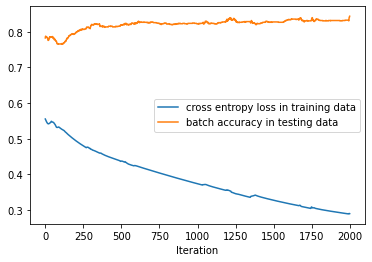

In [ ]:
hp = [torch.eye(dm, requires_grad=True), w_kb.clone().detach().requires_grad_(True)]
opt_hp = torch.optim.Adam(hp, lr=1e-3)
a_kb_opt = a_kb.clone().detach().requires_grad_(False)

totIter = 2000

init_o_loss = outer_loss_class_atten(x_train, y_train, hp[1], a_train, a_kb_opt, hp[0])
init_acc = acc_binary_atten(x_test, y_test, hp[1], a_test, a_kb_opt, hp[0])
print('init outer loss {}; init acc {}'.format(init_o_loss, init_acc))
l_lst = []
acc_lst = []
for tot in range(totIter):
 
  o_loss =  outer_loss_class_atten(x_train, y_train, hp[1], a_train, a_kb_opt, hp[0])

  #x_loss, y_loss, w_kbb, e_item, e_kbb, w_atten
  batch_acc = acc_binary_atten(x_test, y_test, hp[1], a_test, a_kb_opt, hp[0])

  o_loss = o_loss + 0.00001*torch.pow(torch.norm(hp[1]), 2)

  opt_hp.zero_grad()
  o_loss.backward()
  opt_hp.step()


  a_kb_opt, kl_loss = attention_alignment(w_train, hp[1].clone().detach(), a_train, a_kb_opt, hp[0], x_train)
  #a = pppp

  l_lst.append(utils.toNumpy(o_loss))
  acc_lst.append(utils.toNumpy(batch_acc))
  
  if (tot+1) % 10 == 0:
    print('{}/{} o_loss {}; mean test acc {} with mse loss in atten align {}'.format(tot+1, totIter, o_loss, batch_acc, kl_loss))
    #print('{}/{} o_loss {}; mean test acc {} '.format(tot+1, totIter, o_loss, batch_acc))

  #print('hp ', hp)


o_loss = outer_loss_class_atten(x_train, y_train, hp[1], a_train, a_kb_opt, hp[0])
batch_acc = acc_binary_atten(x_test, y_test, hp[1], a_test, a_kb_opt, hp[0])
print('test set: outer loss {}; batch acc {}'.format(o_loss, batch_acc))


plt.plot(l_lst, label='cross entropy loss in training data')
plt.plot(acc_lst, label='batch accuracy in testing data')
plt.xlabel('Iteration')
plt.legend()
plt.show()

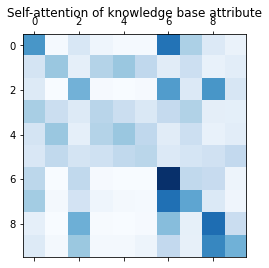

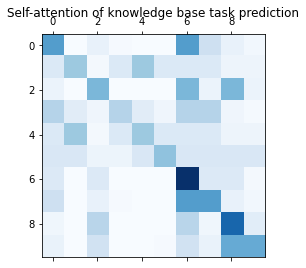

In [ ]:
w_eye = torch.eye(a_kb.size()[0])

a_kb_affinity = build_c_byAtten(a_kb_opt, a_kb_opt, w_eye)
#print(torch.exp(a_kb_affinity))

softmax = nn.Softmax(dim=1)
c_attr_attr = softmax(a_kb_affinity)
#print('c_attr_attr ',c_attr_attr, torch.sum(c_attr_attr, dim=1))

y_kb = torch.matmul(hp[1].t(), x_train)
y_kb[y_kb>=0] = torch.ones_like(y_kb[y_kb>=0])
y_kb[y_kb<0] = torch.zeros_like(y_kb[y_kb<0])
#print('y_kb ', y_kb.size())

w_eye = torch.eye(y_kb.size()[1])
y_kb_affinity = build_c_byAtten(y_kb.t(), y_kb.t(), w_eye)
c_y_y = softmax(y_kb_affinity)
#print('c_y_y ',c_y_y)

plt.matshow(utils.toNumpy(c_attr_attr), cmap=plt.cm.Blues)
plt.title('Self-attention of knowledge base attribute')
plt.show()

plt.matshow(utils.toNumpy(c_y_y ), cmap=plt.cm.Blues)
plt.title('Self-attention of knowledge base task prediction')
plt.show()

#sparsemax

In [ ]:
def analytical_soln_atten(w_kbb, e_item, e_kbb, w_atten):
  #find analytical son for one specific novel task
  '''
  c - row vector 
  w_kbb - hp (list)
  '''
  affinity = build_c_byAtten(e_item, e_kbb, w_atten)

  sparsemax = Sparsemax(dim=1)
  c_newnew = sparsemax(affinity)
  
  w = torch.matmul(c_newnew, w_kbb.t())

  return w.t()

init outer loss 0.5575078129768372; init acc 0.7979999780654907
10/2000 o_loss 0.536930501461029; mean test acc 0.8050000071525574 with mse loss in atten align 0.01586596481502056
20/2000 o_loss 0.5235946178436279; mean test acc 0.7940000295639038 with mse loss in atten align 0.009174272418022156
30/2000 o_loss 0.5326286554336548; mean test acc 0.7879999876022339 with mse loss in atten align 0.005260645877569914
40/2000 o_loss 0.5468997359275818; mean test acc 0.784000039100647 with mse loss in atten align 0.0032132454216480255
50/2000 o_loss 0.5441364645957947; mean test acc 0.7919999957084656 with mse loss in atten align 0.0021438496187329292
60/2000 o_loss 0.5214981436729431; mean test acc 0.7989999651908875 with mse loss in atten align 0.0015524397604167461
70/2000 o_loss 0.4990038573741913; mean test acc 0.8020000457763672 with mse loss in atten align 0.0012115187710151076
80/2000 o_loss 0.4895666539669037; mean test acc 0.8060000538825989 with mse loss in atten align 0.0010564404

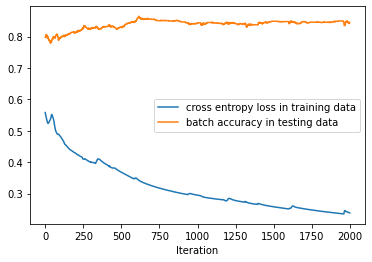

In [ ]:
hp = [torch.eye(dm, requires_grad=True), w_kb.clone().detach().requires_grad_(True)]
opt_hp = torch.optim.Adam(hp, lr=1e-3)
a_kb_opt = a_kb.clone().detach().requires_grad_(False)

totIter = 2000

init_o_loss = outer_loss_class_atten(x_train, y_train, hp[1], a_train, a_kb_opt, hp[0])
init_acc = acc_binary_atten(x_test, y_test, hp[1], a_test, a_kb_opt, hp[0])
print('init outer loss {}; init acc {}'.format(init_o_loss, init_acc))
l_lst = []
acc_lst = []
for tot in range(totIter):
 
  o_loss =  outer_loss_class_atten(x_train, y_train, hp[1], a_train, a_kb_opt, hp[0])

  #x_loss, y_loss, w_kbb, e_item, e_kbb, w_atten
  batch_acc = acc_binary_atten(x_test, y_test, hp[1], a_test, a_kb_opt, hp[0])

  o_loss = o_loss + 0.00001*torch.pow(torch.norm(hp[1]), 2)

  opt_hp.zero_grad()
  o_loss.backward()
  opt_hp.step()


  a_kb_opt, kl_loss = attention_alignment(w_train, hp[1].clone().detach(), a_train, a_kb_opt, hp[0], x_train)
  #a = pppp

  l_lst.append(utils.toNumpy(o_loss))
  acc_lst.append(utils.toNumpy(batch_acc))
  
  if (tot+1) % 10 == 0:
    print('{}/{} o_loss {}; mean test acc {} with mse loss in atten align {}'.format(tot+1, totIter, o_loss, batch_acc, kl_loss))
    #print('{}/{} o_loss {}; mean test acc {} '.format(tot+1, totIter, o_loss, batch_acc))

  #print('hp ', hp)


o_loss = outer_loss_class_atten(x_train, y_train, hp[1], a_train, a_kb_opt, hp[0])
batch_acc = acc_binary_atten(x_test, y_test, hp[1], a_test, a_kb_opt, hp[0])
print('test set: outer loss {}; batch acc {}'.format(o_loss, batch_acc))


plt.plot(l_lst, label='cross entropy loss in training data')
plt.plot(acc_lst, label='batch accuracy in testing data')
plt.xlabel('Iteration')
plt.legend()
plt.show()

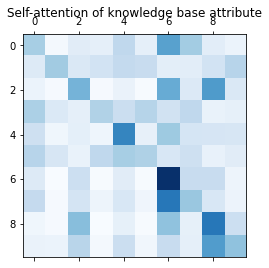

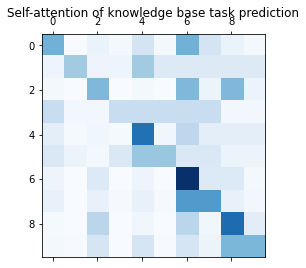

In [ ]:
w_eye = torch.eye(a_kb.size()[0])
a_kb_affinity = build_c_byAtten(a_kb_opt, a_kb_opt, w_eye)
#print(torch.exp(a_kb_affinity))

softmax = nn.Softmax(dim=1)
c_attr_attr = softmax(a_kb_affinity)
#print('c_attr_attr ',c_attr_attr, torch.sum(c_attr_attr, dim=1))

y_kb = torch.matmul(hp[1].t(), x_train)
y_kb[y_kb>=0] = torch.ones_like(y_kb[y_kb>=0])
y_kb[y_kb<0] = torch.zeros_like(y_kb[y_kb<0])
#print('y_kb ', y_kb.size())

w_eye = torch.eye(y_kb.size()[1])
y_kb_affinity = build_c_byAtten(y_kb.t(), y_kb.t(), w_eye)
c_y_y = softmax(y_kb_affinity)
#print('c_y_y ',c_y_y)

plt.matshow(utils.toNumpy(c_attr_attr), cmap=plt.cm.Blues)
plt.title('Self-attention of knowledge base attribute')
plt.show()

plt.matshow(utils.toNumpy(c_y_y ), cmap=plt.cm.Blues)
plt.title('Self-attention of knowledge base task prediction')
plt.show()

#double check accuracy

In [ ]:
#x_test, y_test, w_kb_opt, a_test, a_kb, hp

w_pred = analytical_soln_atten(hp[1], a_test, a_kb, hp[0])
#print(w_pred.t().size(), x_loss.size())
logit = torch.matmul(w_pred.t(), x_test)
pred = torch.sigmoid(logit)
pred[pred>=0.5] = torch.ones_like(pred[pred>=0.5])
pred[pred<0.5] = torch.zeros_like(pred[pred<0.5])

compare = (pred == y_test)
#print('compare ', compare.size(), compare)
compare = torch.sum(compare, dim=1)
#print('compare ', compare.size(), compare)
#print(y_loss.size()[1])
acc = torch.mean(compare.float())
#print('acc ', acc)
mean_acc = acc/y_test.size()[1]
print(mean_acc)

tensor(0.7600)


In [ ]:
indx = 1
print(pred[indx,:])
print(y_test[indx,:])
print(torch.sum(pred[indx,:] == y_test[indx,:]), pred[indx,:] == y_test[indx,:])
for i in range(pred.size()[0]):
  print(torch.sum(pred[i,:] == y_test[i,:]))

tensor([0., 1., 1., 0., 0., 1., 1., 1., 0., 1.], grad_fn=<SliceBackward>)
tensor([0., 1., 1., 1., 0., 1., 1., 1., 1., 1.])
tensor(8) tensor([ True,  True,  True, False,  True,  True,  True,  True, False,  True])
tensor(7)
tensor(8)
tensor(9)
tensor(6)
tensor(9)
tensor(7)
tensor(8)
tensor(7)
tensor(7)
tensor(9)
tensor(7)
tensor(7)
tensor(8)
tensor(8)
tensor(9)
tensor(8)
tensor(9)
tensor(8)
tensor(10)
tensor(7)
tensor(5)
tensor(7)
tensor(8)
tensor(8)
tensor(7)
tensor(6)
tensor(9)
tensor(7)
tensor(7)
tensor(9)
tensor(10)
tensor(7)
tensor(4)
tensor(6)
tensor(6)
tensor(9)
tensor(6)
tensor(10)
tensor(8)
tensor(8)
tensor(9)
tensor(9)
tensor(7)
tensor(8)
tensor(4)
tensor(9)
tensor(6)
tensor(5)
tensor(7)
tensor(9)
tensor(6)
tensor(9)
tensor(8)
tensor(5)
tensor(6)
tensor(9)
tensor(7)
tensor(10)
tensor(7)
tensor(7)
tensor(8)
tensor(9)
tensor(8)
tensor(6)
tensor(9)
tensor(6)
tensor(5)
tensor(6)
tensor(9)
tensor(10)
tensor(7)
tensor(7)
tensor(8)
tensor(6)
tensor(8)
tensor(9)
tensor(10)
tensor(10)
t